# Derivation of phase angle given orbital parameters from Sec 2.2 of Lacy 2019
https://ui.adsabs.harvard.edu/abs/2019AJ....157..132L/abstract

Phase angle $\alpha$ given inclincation $i$, argument of periastron $\omega_p$, and true anomaly $\theta$:
$$\alpha = \cos^{-1} (\sin i \times \sin(\theta + \omega_p)$$
where:
$$\theta = 2 \tan^{-1} \big( \sqrt{\frac{1+e}{1-e}} \tan(E/2)$$
with eccentricity e and eccentricity anomaly E from mean anomaly M:
$$ M = E - e \sin E$$
$$ M = \frac{2\pi t}{P}$$
where t is time of observation and P is period

In [1]:
def eccentricity_anomaly(E,e,M):
    '''Eccentric anomaly function'''
    import numpy as np
    return E - (e*np.sin(E)) - M

def danby_solve(f, M0, e, h, maxnum=50):
    ''' Newton-Raphson solver for eccentricity anomaly based on "Danby" method in 
        Wisdom textbook
    Inputs: 
        f (function): function to solve (transcendental ecc. anomaly function)
        M0 (float): mean anomaly
        e (float): eccentricity
        h (float): termination criteria for solver
        maxnum (int): if it takes more than maxnum iterations,
            use the Mikkola solver instead.
    Returns: nextE (float): converged solution for eccentric anomaly
        Written by Logan Pearce, 2020
    '''
    import numpy as np
    from myastrotools.tools import eccentricity_anomaly
    #f = eccentricity_anomaly
    k = 0.85
    E0 = M0 + np.sign(np.sin(M0))*k*e
    lastE = E0
    nextE = lastE + 10* h 
    number=0
    delta_D = 1
    while (delta_D > h) and number < maxnum+1: 
        fx = f(nextE,e,M0) 
        fp = (1.-e*np.cos(lastE)) 
        fpp = e*np.sin(lastE)
        fppp = e*np.cos(lastE)
        lastE = nextE
        delta_N = -fx / fp
        delta_H = -fx / (fp + 0.5*fpp*delta_N)
        delta_D = -fx / (fp + 0.5*fpp*delta_H + (1./6)*fppp*delta_H**2)
        nextE = lastE + delta_D
        number=number+1
        if number >= maxnum:
            from myastrotools.tools import mikkola_solve
            nextE = mikkola_solve(M0,e)
    return nextE

def mikkola_solve(M,e):
    ''' Analytic solver for eccentricity anomaly from Mikkola 1987. Most efficient
        when M near 0/2pi and e >= 0.95.
    Inputs: 
        M (float): mean anomaly
        e (float): eccentricity
    Returns: eccentric anomaly
        Written by Logan Pearce, 2020
    '''
    # Constants:
    alpha = (1 - e) / ((4.*e) + 0.5)
    beta = (0.5*M) / ((4.*e) + 0.5)
    ab = np.sqrt(beta**2. + alpha**3.)
    z = np.abs(beta + ab)**(1./3.)

    # Compute s:
    s1 = z - alpha/z
    # Compute correction on s:
    ds = -0.078 * (s1**5) / (1 + e)
    s = s1 + ds

    # Compute E:
    E0 = M + e * ( 3.*s - 4.*(s**3.) )

    # Compute final correction to E:
    sinE = np.sin(E0)
    cosE = np.cos(E0)

    f = E0 - e*sinE - M
    fp = 1. - e*cosE
    fpp = e*sinE
    fppp = e*cosE
    fpppp = -fpp

    dx1 = -f / fp
    dx2 = -f / (fp + 0.5*fpp*dx1)
    dx3 = -f / ( fp + 0.5*fpp*dx2 + (1./6.)*fppp*(dx2**2) )
    dx4 = -f / ( fp + 0.5*fpp*dx3 + (1./6.)*fppp*(dx3**2) + (1./24.)*(fpppp)*(dx3**3) )

    return E0 + dx4

def GetPhaseAngle(MeanAnom, ecc, inc, argp):
    ''' Function for returning observed phase angle given orbital elements
    Args:
        MeanAnom (flt): Mean anomly in radians, where MeanAnom = orbit fraction*2pi, or M=2pi * time/Period
        ecc (flt): eccentricity, defined on [0,1)
        inc (flt): inclination in degrees, where inc = 90 is edge on, inc = 0 or 180 is face on orbit
        argp (flt): argument of periastron in degrees, defined on [0,360)
        
    Returns:
        flt: phase angle in degrees
    Written by Logan Pearce, 2023
    '''
    import numpy as np
    inc = np.radians(inc)
    argp = np.radians(argp)
    EccAnom = danby_solve(eccentricity_anomaly, MeanAnom, ecc, 0.001, maxnum=50)
    TrueAnom = 2*np.arctan( np.sqrt( (1+ecc)/(1-ecc) ) * np.tan(EccAnom/2) )
    Alpha = np.arccos( np.sin(inc) * np.sin(TrueAnom + argp) )
    
    return np.degrees(Alpha)

<IPython.core.display.Javascript object>


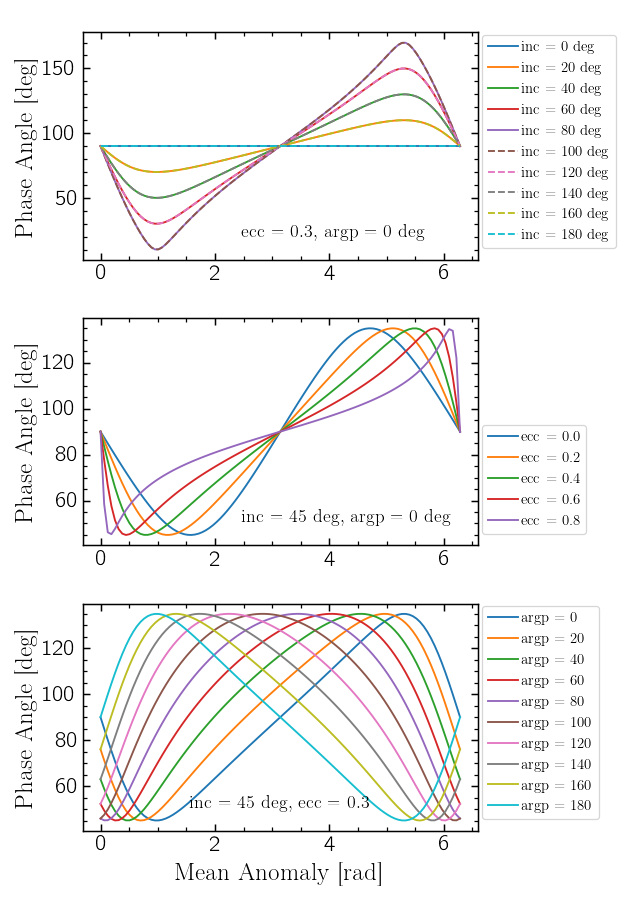

In [34]:

MeanAnom = np.linspace(0, 2*np.pi, 100)


%matplotlib notebook
plt.figure(figsize=(7,10))
plt.subplot(311)
ecc = 0.3
argp = 0 #degrees
inc = np.arange(0,200,20) #degrees
for i in inc:
    alpha = np.array([GetPhaseAngle(M, ecc, i, argp) for M in MeanAnom])
    if i > 90:
        plt.plot(MeanAnom, alpha, label='inc = '+str(i)+' deg', ls='--')
    else:
        plt.plot(MeanAnom, alpha, label='inc = '+str(i)+' deg')
plt.annotate('ecc = 0.3, argp = 0 deg', xy=(0.4,0.1), xycoords='axes fraction', fontsize=15)
#plt.xlabel('Mean Anomaly [rad]')
plt.ylabel('Phase Angle [deg]')
#plt.title('Phase angle vs Mean Anomally dependence on inclination')
plt.legend(loc=(1.01,0.05), fontsize=12)


plt.subplot(312)
inc = 45 #degrees
ecc = np.arange(0,0.95,0.2)
argp = 0

for e in ecc:
    alpha = np.array([GetPhaseAngle(M, e, inc, argp) for M in MeanAnom])
    plt.plot(MeanAnom, alpha, label='ecc = {:.1f}'.format(e))
plt.annotate('inc = 45 deg, argp = 0 deg', xy=(0.4,0.1), xycoords='axes fraction', fontsize=15)
#plt.xlabel('Mean Anomaly [rad]')
plt.ylabel('Phase Angle [deg]')
#plt.title('Phase angle vs Mean Anomally dependence on inclination')
plt.legend(loc=(1.01,0.05), fontsize=12)

plt.subplot(313)
inc = 45 #degrees
ecc = 0.3
argp = np.arange(0,200,20)

for w in argp:
    alpha = np.array([GetPhaseAngle(M, ecc, inc, w) for M in MeanAnom])
    plt.plot(MeanAnom, alpha, label='argp = {:.0f}'.format(w))
plt.annotate('inc = 45 deg, ecc = 0.3', xy=(0.27,0.1), xycoords='axes fraction', fontsize=15)
plt.xlabel('Mean Anomaly [rad]')
plt.ylabel('Phase Angle [deg]')
#plt.title('Phase angle vs Mean Anomally dependence on inclination')
plt.legend(loc=(1.01,0.05), fontsize=12)




plt.tight_layout()
plt.savefig('Phase-angle-dependance-on-orbital-elements.png',bbox_inches='tight')